## Demo for Proximal_Policy_Optimization

---- 

conda env : [rl_learning](../Book_deep_learning_from_scratch_4/README.md#setup-a-conda-environment)

---
### Reference:

- ***Github***:
    - https://github.com/MaximeVandegar/Papers-in-100-Lines-of-Code/blob/main/Proximal_Policy_Optimization_Algorithms/ppo.py


In [1]:
import os
import gymnasium as gym
import torch
import ale_py
import random
import numpy as np
from tqdm import tqdm
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from stable_baselines3.common.atari_wrappers import MaxAndSkipEnv
from torch.utils.data import DataLoader, TensorDataset
from pathlib import Path
from IPython.display import clear_output

In [2]:
# Pytorch Device
if torch.backends.mps.is_available():
    g_device = torch.device("mps")
elif torch.cuda.is_available():
    g_device = torch.device("cuda")
else:
    g_device = torch.device("cpu")

print(g_device)

g_mode_save_dir = "./temp/ppo_2/model"
Path(g_mode_save_dir).mkdir(exist_ok=True, parents=True)

mps


In [3]:
class ActorCritic(nn.Module):
    def __init__(self, nb_actions):
        super().__init__()
        self.head = nn.Sequential(nn.Conv2d(4, 16, 8, stride=4), nn.Tanh(),
                                  nn.Conv2d(16, 32, 4, stride=2), nn.Tanh(),
                                  nn.Flatten(), nn.Linear(2592, 256), nn.Tanh(),)
        # self.head = nn.Sequential(nn.Conv2d(12, 16, 8, stride=4), nn.Tanh(),
        #                           nn.Conv2d(16, 32, 4, stride=2), nn.Tanh(),
        #                           nn.Flatten(), nn.Linear(2592, 256), nn.Tanh(),)
        self.actor = nn.Sequential(nn.Linear(256, nb_actions))
        self.critic = nn.Sequential(nn.Linear(256, 1),)

    def forward(self, x):
        h = self.head(x)
        return self.actor(h), self.critic(h)

In [4]:
class Environments():
    def __init__(self, nb_actor):
        self.envs = [self.get_env() for _ in range(nb_actor)]
        self.observations = [None for _ in range(nb_actor)]
        self.current_life = [None for _ in range(nb_actor)]
        self.done = [False for _ in range(nb_actor)]
        self.total_rewards = [0 for _ in range(nb_actor)]
        self.nb_actor = nb_actor

        for env_id in range(nb_actor):
            self.reset_env(env_id)

    def len(self):
        return self.nb_actor

    def reset_env(self, env_id):
        self.total_rewards[env_id] = 0
        self.envs[env_id].reset()

        for _ in range(random.randint(1, 30)):  # Noop and fire to reset environment
            self.observations[env_id], reward, _, _, info = self.envs[env_id].step(1)
            self.total_rewards[env_id] += reward
            self.current_life[env_id] = info['lives']
        # action = self.envs[env_id].action_space.sample()

        # # Or, if you need a specific action, define it as a NumPy array:
        # # action = np.array([0.0, 0.0, 0.0]) # Example for a zero-torque action

        # self.observations[env_id], reward, terminated, truncated, info = self.envs[env_id].step(action)

    def step(self, env_id, action):
        # next_obs, reward, dead, info = self.envs[env_id].step(action)
        next_obs, reward, terminated, truncated, info = self.envs[env_id].step(action)
        dead = terminated or truncated
        done = True if (info['lives'] < self.current_life[env_id]) else False
        self.done[done] = done
        self.total_rewards[env_id] += reward
        self.current_life[env_id] = info['lives']
        self.observations[env_id] = next_obs
        return next_obs, reward, dead, done, info

    def get_env(self):
        # env = gym.make("BreakoutNoFrameskip-v4")
        # env = gym.make("Hopper-v4")
        env = gym.make("ALE/Breakout-v5")
        env = gym.wrappers.RecordEpisodeStatistics(env)
        env = gym.wrappers.ResizeObservation(env, (84, 84))
        env = gym.wrappers.GrayscaleObservation(env)
        env = gym.wrappers.FrameStackObservation(env, 4)
        env = MaxAndSkipEnv(env, skip=4)
        return env

In [5]:
def PPO(envs, T=128, K=3, batch_size=32*8, gamma=0.99, device='cuda', gae_parameter=0.95,
        vf_coeff_c1=1, ent_coef_c2=0.01, nb_iterations=40_000):

    optimizer = torch.optim.Adam(actorcritic.parameters(), lr=2.5e-4)
    scheduler = torch.optim.lr_scheduler.LinearLR(
        optimizer, start_factor=1., end_factor=0.0, total_iters=nb_iterations)

    max_reward = 0
    total_rewards = [[] for _ in range(envs.len())]
    smoothed_rewards = [[] for _ in range(envs.len())]

    for iteration in tqdm(range(nb_iterations)):
        advantages = torch.zeros((envs.len(), T), dtype=torch.float32, device=device)
        buffer_states = torch.zeros((envs.len(), T, 4, 84, 84), dtype=torch.float32, device=device)
        buffer_actions = torch.zeros((envs.len(), T), dtype=torch.long, device=device)
        buffer_logprobs = torch.zeros((envs.len(), T), dtype=torch.float32, device=device)
        buffer_state_values = torch.zeros((envs.len(), T+1), dtype=torch.float32, device=device)
        buffer_rewards = torch.zeros((envs.len(), T), dtype=torch.float32, device=device)
        buffer_is_terminal = torch.zeros((envs.len(), T), dtype=torch.float16, device=device)

        for env_id in range(envs.len()):
            with torch.no_grad():
                for t in range(T):  # Run policy θ_old in environment for T timesteps
                    obs = torch.from_numpy(envs.observations[env_id] / 255.).unsqueeze(0).float().to(device)
                    obs = obs.reshape(obs.shape[0], -1, obs.shape[2], obs.shape[3])
                    logits, value = actorcritic(obs)
                    logits, value = logits.squeeze(0), value.squeeze(0)
                    m = torch.distributions.categorical.Categorical(logits=logits)

                    if envs.done[env_id]:  # Fire to reset env
                        action = torch.tensor([1]).to(device)
                    else:
                        action = m.sample()

                    log_prob = m.log_prob(action)
                    # _, reward, dead, done, _ = envs.step(env_id, action)
                    _, reward, terminated, truncated, _ = envs.step(env_id, action)
                    dead = terminated or truncated
                    reward = np.sign(reward)  # Reward clipping

                    buffer_states[env_id, t] = obs
                    buffer_actions[env_id, t] = torch.tensor([action]).to(device)
                    buffer_logprobs[env_id, t] = log_prob
                    buffer_state_values[env_id, t] = value
                    buffer_rewards[env_id, t] = reward
                    buffer_is_terminal[env_id, t] = dead

                    if dead:
                        if envs.total_rewards[env_id] > max_reward:
                            max_reward = envs.total_rewards[env_id]
                            save_path = os.path.join(g_mode_save_dir, f"actorcritic_{max_reward}.pth")
                            torch.save(actorcritic.cpu(), save_path)
                            actorcritic.to(device)

                        total_rewards[env_id].append(envs.total_rewards[env_id])
                        envs.reset_env(env_id)

                buffer_state_values[env_id, T] = actorcritic(
                    torch.from_numpy(envs.observations[env_id] / 255.).unsqueeze(0).float().to(device))[1].squeeze(0)

                # Compute advantage estimates A^1; ... ; A^T
                for t in range(T-1, -1, -1):
                    next_non_terminal = 1.0 - buffer_is_terminal[env_id, t]
                    delta_t = buffer_rewards[env_id, t] + gamma * buffer_state_values[
                        env_id, t+1] * next_non_terminal - buffer_state_values[env_id, t]
                    if t == (T-1):
                        A_t = delta_t
                    else:
                        A_t = delta_t + gamma * gae_parameter * advantages[env_id, t+1] * next_non_terminal
                    advantages[env_id, t] = A_t

        if (iteration % 100 == 0) and iteration > 0:
            for env_id in range(envs.len()):
                smoothed_rewards[env_id].append(np.mean(total_rewards[env_id]))
                plt.plot(smoothed_rewards[env_id])
            total_rewards = [[] for _ in range(envs.len())]
            clear_output(True)
            plt.title("Average Reward on Breakout")
            plt.xlabel("Training Epochs")
            plt.ylabel("Average Reward per Episode")
            # plt.savefig('average_reward_on_breakout.png')
            # plt.close()
            plt.show()

        for epoch in range(K):
            advantages_data_loader = DataLoader(
                TensorDataset(advantages.reshape(advantages.shape[0] * advantages.shape[1]),
                              buffer_states.reshape(-1, buffer_states.shape[2], buffer_states.shape[3],
                                                    buffer_states.shape[4]),
                              buffer_actions.reshape(-1),
                              buffer_logprobs.reshape(-1),
                              buffer_state_values[:, :T].reshape(-1),),
                batch_size=batch_size, shuffle=True,)

            for batch_advantages in advantages_data_loader:
                b_adv, obs, action_that_was_taken, old_log_prob, old_state_values = batch_advantages

                logits, value = actorcritic(obs)
                logits, value = logits.squeeze(0), value.squeeze(-1)
                m = torch.distributions.categorical.Categorical(logits=logits)
                log_prob = m.log_prob(action_that_was_taken)
                ratio = torch.exp(log_prob - old_log_prob)
                returns = b_adv + old_state_values

                # clipped surrogate objective
                policy_loss_1 = b_adv * ratio
                alpha = 1. - iteration / nb_iterations
                clip_range = 0.1 * alpha
                policy_loss_2 = b_adv * torch.clamp(ratio, 1 - clip_range, 1 + clip_range)
                policy_loss = -torch.min(policy_loss_1, policy_loss_2).mean()

                # clipped value loss; see https://arxiv.org/pdf/2005.12729
                value_loss1 = F.mse_loss(returns, value, reduction='none')
                value_loss2 = F.mse_loss(returns, torch.clamp(value, value - clip_range, value + clip_range),
                                         reduction='none')
                value_loss = torch.max(value_loss1, value_loss2).mean()

                loss = policy_loss + ent_coef_c2 * -(m.entropy()).mean() + vf_coeff_c1 * value_loss

                # θ_old <- θ
                optimizer.zero_grad()
                loss.backward()
                torch.nn.utils.clip_grad_norm_(actorcritic.parameters(), 0.5)
                optimizer.step()
        scheduler.step()

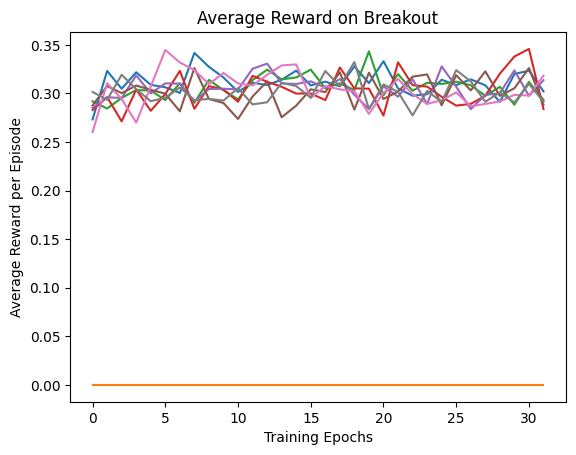

 81%|████████  | 3247/4000 [27:23:28<6:19:49, 30.26s/it]

In [ ]:

nb_actor = 8
envs = Environments(nb_actor)
actorcritic = ActorCritic(envs.envs[0].action_space.n).to(g_device)
PPO(envs, batch_size = 128 * 8, device=g_device, nb_iterations=4000)